In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли
from sklearn import tree

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
# !pip install -U scikit-learn
# %conda install -c intel scikit-learn

### Предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.

### Необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации.

In [3]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# Посмотрим на размер таблицы:
print(shoppers_data.shape)

# В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

(12330, 18)


In [5]:
# Заранее удостоверимся в отсутствии пропусков:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
# Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


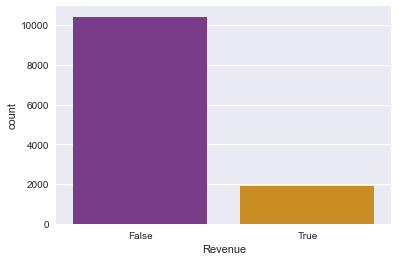

In [7]:
# посмотрим на соотношение классов в данных:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

#### Условимся, что лучшей будет считаться та модель, у которой значение метрики F1 для пользователей, совершивших покупку, будет наибольшим.

In [8]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Заранее определимся, как будем производить контроль качества моделей:

* Разделим выборку на тренировочную и тестовую.
* Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Будем использовать три показателя:

* значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
* значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
* Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [9]:
#разбиваем исходную выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print('Train:\n', y_train.value_counts(normalize=False), sep='')
print('Test:\n', y_test.value_counts(normalize=False), sep='')

print('Train:\n', y_train.value_counts().sum(), sep='')
print('Test:\n', y_test.value_counts().sum(), sep='')


Train:
False    8367
True     1497
Name: Revenue, dtype: int64
Test:
False    2055
True      411
Name: Revenue, dtype: int64
Train:
9864
Test:
2466


### Задание 6.3

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — -score.

Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [11]:
# Создаём модель
model_ravenue = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    # max_depth=7, #максимальная глубина
    # min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model_ravenue, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

display(cv_metrics)

{'fit_time': array([1.07714701, 1.08623672, 1.03445148, 1.03665829, 1.03940272]),
 'score_time': array([0.05025291, 0.04915357, 0.05341601, 0.05712199, 0.05674291]),
 'test_score': array([0.68497577, 0.66666667, 0.63714286, 0.56676558, 0.58171745]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [12]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.63


### Задание 6.5

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

Случайный лес из деревьев максимальной глубины 5.
Случайный лес из деревьев максимальной глубины 7.
Случайный лес из деревьев максимальной глубины 12.
Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

In [13]:
# Создаём модель
model_ravenue_5 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=5, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_5.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_5 = model_selection.cross_validate(
    estimator=model_ravenue_5, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

display(cv_metrics_5)

{'fit_time': array([1.04876423, 1.05377126, 1.09598827, 1.04216051, 1.10269618]),
 'score_time': array([0.06137753, 0.06619978, 0.06696534, 0.06343675, 0.06719208]),
 'test_score': array([0.42253521, 0.52059925, 0.53873239, 0.39922481, 0.51048951]),
 'train_score': array([0.51746324, 0.53064959, 0.53846154, 0.54669704, 0.54778235])}

In [14]:
# Создаём модель
model_ravenue_7 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_7.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_7 = model_selection.cross_validate(
    estimator=model_ravenue_7, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

In [15]:
# Создаём модель
model_ravenue_12 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=12, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_12.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_12 = model_selection.cross_validate(
    estimator=model_ravenue_12, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

In [16]:
print('Глубина леса 5')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_5['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_5['test_score'])))
print('__________________________________________________________________________')
print('Глубина леса 7')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_7['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_7['test_score'])))
print('__________________________________________________________________________')
print('Глубина леса 12')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_12['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_12['test_score'])))

Глубина леса 5
Train k-fold mean f1: 0.54
Valid k-fold mean f1: 0.48
__________________________________________________________________________
Глубина леса 7
Train k-fold mean f1: 0.68
Valid k-fold mean f1: 0.60
__________________________________________________________________________
Глубина леса 12
Train k-fold mean f1: 0.78
Valid k-fold mean f1: 0.62


In [17]:
model = ensemble.RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

       False       0.90      0.98      0.94      2055
        True       0.81      0.45      0.58       411

    accuracy                           0.89      2466
   macro avg       0.85      0.72      0.76      2466
weighted avg       0.88      0.89      0.88      2466



In [20]:
# %conda update scikit-learn


Solving environment: ...working... done

## Package Plan ##

  environment location: c:\ProgramData\Anaconda3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anaconda-client-1.11.0     |   py39haa95532_0         165 KB
    anaconda-project-0.11.1    |   py39haa95532_0         511 KB
    anyio-3.5.0                |   py39haa95532_0         167 KB
    argon2-cffi-21.3.0         |     pyhd3eb1b0_0          15 KB
    arrow-1.2.2                |     pyhd3eb1b0_0          92 KB
    astropy-5.1                |   py39h080aedc_0         6.4 MB
    attrs-21.4.0               |     pyhd3eb1b0_0          51 KB
    autopep8-1.6.0             |     pyhd3eb1b0_0          42 KB
    backports-1.1              |     pyhd3eb1b0_0           4 KB
    bcrypt-3.2.0               |   py39h2bbff1b_1          37 KB
    beautifulsoup4-4.11.1      |   py39haa95532_0

ERROR conda.core.link:_execute(733): An error occurred while installing package 'defaults::scipy-1.7.3-py39h7a0a035_2'.

CondaError: Cannot link a source that does not exist. c:\ProgramData\Anaconda3\.condatmp\758e4547-2849-419c-ba68-99035fbf2942
Running `conda clean --packages` may resolve your problem.
()
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\ca-certificates-2022.07.19-haa95532_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\icc_rt-2019.0.0-h0cc432a_1.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\tzdata-2021e-hda174b7_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\m2w64-gmp-6.1.0-2.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\brotli-1.0.9-ha925a31_2.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\cfitsio-3.470-he774522_6.json'


  fftw               pkgs/main/win-64::fftw-3.3.9-h2bbff1b_1 None
  libbrotlicommon    pkgs/main/win-64::libbrotlicommon-1.0.9-h2bbff1b_7 None
  libbrotlidec       pkgs/main/win-64::libbrotlidec-1.0.9-h2bbff1b_7 None
  libbrotlienc       pkgs/main/win-64::libbrotlienc-1.0.9-h2bbff1b_7 None
  libsodium          pkgs/main/win-64::libsodium-1.0.18-h62dcd97_0 None
  lz4                pkgs/main/win-64::lz4-3.1.3-py39h2bbff1b_0 None
  pathlib            pkgs/main/noarch::pathlib-1.0.1-pyhd3eb1b0_1 None
  platformdirs       pkgs/main/win-64::platformdirs-2.5.2-py39haa95532_0 None
  zeromq             pkgs/main/win-64::zeromq-4.3.4-hd77b12b_0 None

The following packages will be REMOVED:

  argh-0.26.2-py39haa95532_0
  asn1crypto-1.4.0-py_0
  async_generator-1.10-pyhd3eb1b0_0
  backports.shutil_get_terminal_size-1.0.0-pyhd3eb1b0_3
  boto-2.49.0-py39haa95532_0
  cached-property-1.5.2-py_0
  contextlib2-0.6.0.post1-pyhd3eb1b0_0
  fastcache-1.1.0-py39h196d8e1_0
  get_terminal_size-1.0.0-h38e98d


[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\jpeg-9d-h2bbff1b_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\krb5-1.19.2-h5b6d351_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\libiconv-1.15-h1df5818_7.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\liblief-0.10.1-hd77b12b_1.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\libwebp-1.2.0-h2bbff1b_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\m2w64-gcc-libs-core-5.3.0-7.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\openssl-1.1.1q-h2bbff1b_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\snappy-1.1.8-h33f27b4_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\sqlite-3.36.0-h2bbff1b_0.json'
[Errno 2] No such file

  googleapis-common~                  1.53.0-py39h2eaa2aa_0 --> 1.56.4-py39haa95532_0 None
  h5py                                 3.2.1-py39h3de5c98_0 --> 3.7.0-py39h3de5c98_0 None
  hdf5                                    1.10.6-h7ebc959_0 --> 1.10.6-h1756f20_1 None
  holoviews          pkgs/main/noarch::holoviews-1.14.8-py~ --> pkgs/main/win-64::holoviews-1.15.0-py39haa95532_0 None
  hvplot             pkgs/main/noarch::hvplot-0.7.3-pyhd3e~ --> pkgs/main/win-64::hvplot-0.8.0-py39haa95532_0 None
  icc_rt                                2019.0.0-h0cc432a_1 --> 2022.1.0-h6049295_1 None
  idna                                     3.2-pyhd3eb1b0_0 --> 3.3-pyhd3eb1b0_0 None
  imageio            pkgs/main/noarch::imageio-2.9.0-pyhd3~ --> pkgs/main/win-64::imageio-2.19.3-py39haa95532_0 None
  imagesize          pkgs/main/noarch::imagesize-1.2.0-pyh~ --> pkgs/main/win-64::imagesize-1.4.1-py39haa95532_0 None
  importlib-metadata                   4.8.1-py39haa95532_0 --> 4.11.3-py39haa95532_0 No

[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\pytz-2021.3-pyhd3eb1b0_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\qtpy-1.10.0-pyhd3eb1b0_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\qtawesome-1.0.2-pyhd3eb1b0_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\requests-2.26.0-pyhd3eb1b0_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\pyct-0.4.6-py39haa95532_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\rope-0.19.0-pyhd3eb1b0_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\six-1.16.0-pyhd3eb1b0_0.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\argon2-cffi-20.1.0-py39h2bbff1b_1.json'
[Errno 2] No such file or directory: 'c:\\ProgramData\\Anaconda3\\conda-meta\\cycler-0.10.0-py39haa95532_0.json